# Write a Data Science Blog Post - Spotify Tracks

# Business Understanding

Accompanying notebook for first project of Udacity Data Science Nanodegree.

We will be looking at Spotify music tracks in the Great Britain market, and performing analysis to answer the following questions:
* Who are the most popular artists and what are the most popular tracks on Spotify for the GB market?
* How did various audio features change over time?
* What contributes to song popularity, and can we predict a song's popularity?

The data set contains details of around 100k tracks released from 1922 to 2021, collected from the Spotify Web API and uploaded to kaggle.com by Yamac Eren Ay.  The data includes tracks released up to 15th April 2021.

### Import the relevant packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import statsmodels.api as sm
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

%matplotlib inline
sns.set_palette("colorblind")
color_palette20 = sns.color_palette("colorblind", 20)

# Data Understanding

### Import the data set

In [2]:
df = pd.read_csv('GB_Spotify_Tracks.csv')

### Take a look at the first few rows of data

In [3]:
df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,0,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,0,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,1,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,3,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4


### Find the shape of that data

In [4]:
df.shape

(94469, 20)

The data has 94,469 rows and 20 columns.

### Find the data type of each column in the data

In [5]:
df.dtypes

id                   object
name                 object
popularity            int64
duration_ms           int64
explicit              int64
artists              object
id_artists           object
release_date         object
danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature        int64
dtype: object

### Create a copy of the dataset which will be the one we work on

In [6]:
tracks_df = df.copy()

### Count the rows with missing values

In [7]:
tracks_df.shape[0] - tracks_df.dropna().shape[0]

0

There are no missing values in the dataset, but it's possible that missing values were dealt with by the creator of the dataset or missing values were replaced with some dummy value like 0.

### Explore potential relationships between the continuous variables

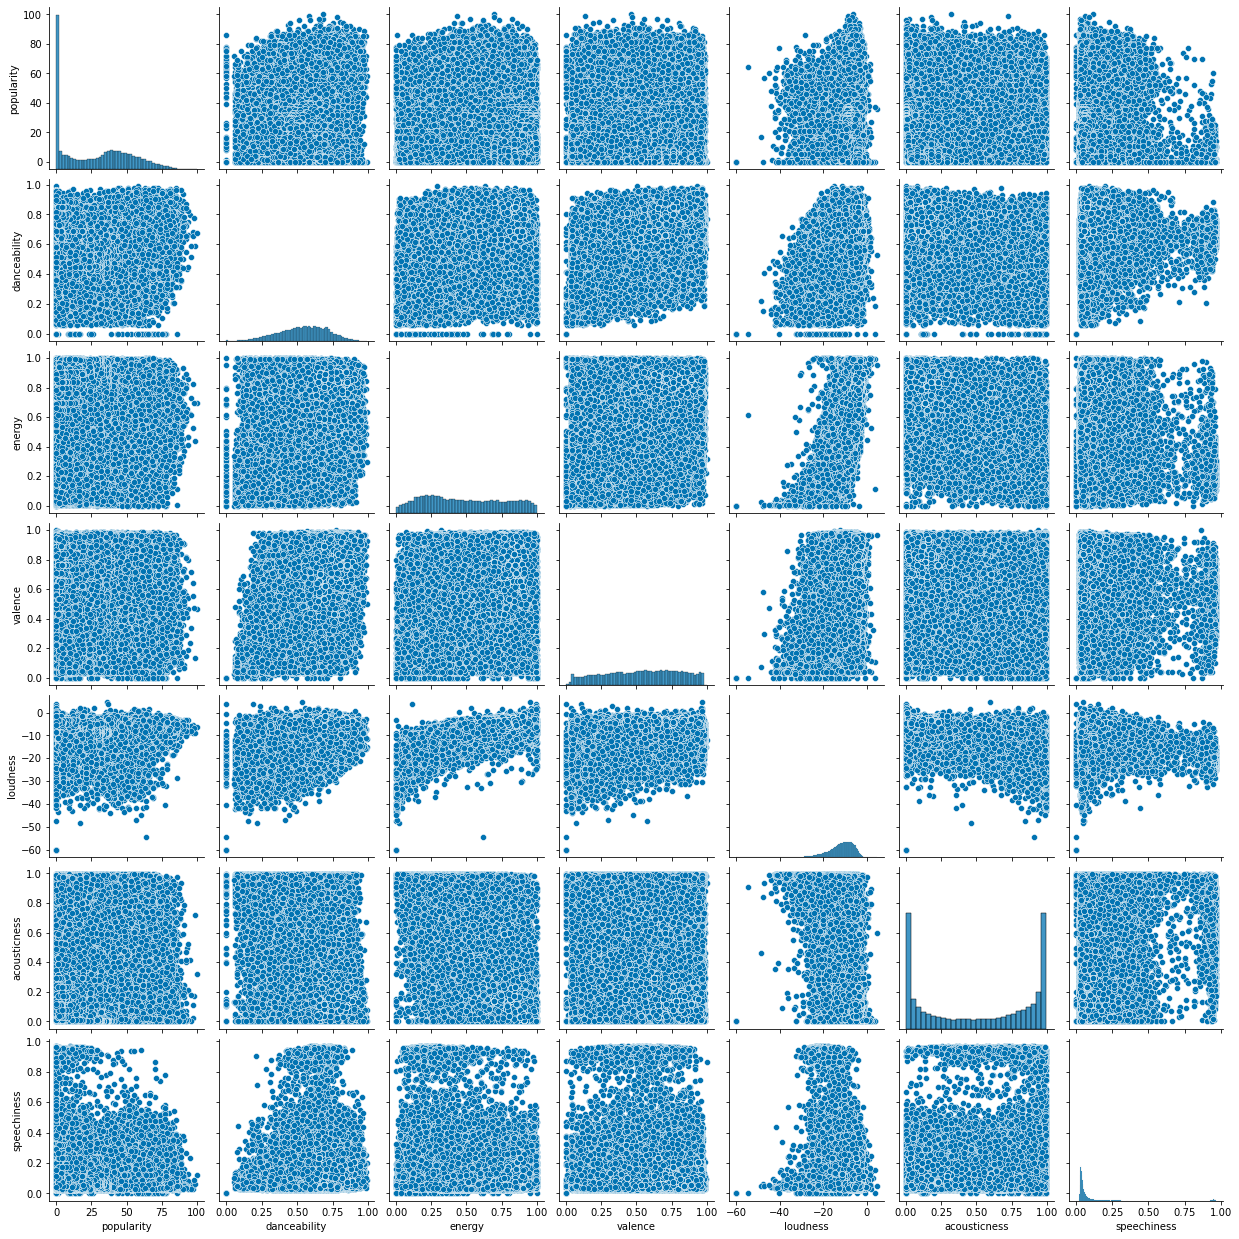

In [8]:
sns.pairplot(tracks_df[["popularity", "danceability", "energy", "valence", "loudness", "acousticness", "speechiness"]])

The pairplots don't tell us much in terms of relationships between variables.  We would mostly be interested in popularity's relationship with the other variables, but it looks like the only feature it may have a relationship with is speechiness.  Loudness does appear to have some relationship with energy, with higher energy being associated with higher loudness in tracks.

# Data Preparation

### Extract the year from the release date to use as a variable

In [9]:
tracks_df['release_year'] = pd.to_datetime(tracks_df['release_date']).dt.year

In [10]:
tracks_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.4450,...,-13.338,1,0.4510,0.674,0.7440,0.151,0.127,104.851,3,1922
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.2630,...,-22.136,1,0.9570,0.797,0.0000,0.148,0.655,102.009,1,1922
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.1770,...,-21.180,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,1922
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,...,-27.961,1,0.0504,0.995,0.9180,0.104,0.397,169.980,3,1922
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.1580,...,-16.900,0,0.0390,0.989,0.1300,0.311,0.196,103.220,4,1922


### Plot number of tracks released by year

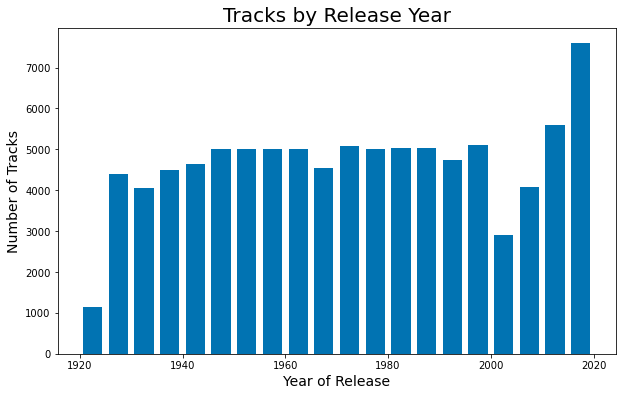

In [11]:
year = tracks_df["release_year"]

plt.figure(figsize=[10,6])
plt.hist(year, bins=range(1920, 2021, 5), rwidth=0.75)
plt.title('Tracks by Release Year', fontsize=20)
plt.xlabel('Year of Release', fontsize=14)
plt.ylabel('Number of Tracks', fontsize=14)
plt.show()

Out dataset is fairly consistent, with around 5000 tracks in every 5-year bin.  The number of tracks is more unevenly spread after the year 2000.

### Perform mapping on some of the categorical columns

In [12]:
# Currently the keys are coded as integers from 0-11, the dataset documentation highlights that 0 correspends to the key
# C, 1 corresponds to C#/Db, and so on.  So we'll map these to their string values
keys_dict = {0: "C", 1: "C#/Db", 2: "D", 3: "D#/Eb", 4: "E", 5: "F", 6: "F#/Gb", 7: "G", 8: "G#/Ab", 9: "A", 10: "A#/Bb", 11: "B"}

tracks_df["key"] = tracks_df["key"].map(keys_dict)

In [13]:
# The dataset documentation notes that in the mode column, a 0 denotes minor key and 1 denotes major key
mode_dict = {0: "minor", 1: "major"}

tracks_df["mode"] = tracks_df["mode"].map(mode_dict)

In [14]:
# The dataset documentation notes that in the explicit column, 0 denotes no explicit content and 1 denotes explicit content
explicit_dict = {0: "no", 1: "yes"}

tracks_df["explicit"] = tracks_df["explicit"].map(explicit_dict)

In [15]:
tracks_df[["explicit", "mode", "key"]]

,explicit,mode,key
0,no,major,C
1,no,major,C
2,no,major,C#/Db
3,no,major,G
4,no,minor,D#/Eb
...,...,...,...
94464,no,minor,G#/Ab
94465,no,minor,G#/Ab
94466,no,minor,F#/Gb
94467,no,minor,A


We will try and build a machine learning model to predict song popularity, so let's take a copy of our dataframe at this point to perform some extra data preparation.

Our dependent variable is popularity.
The continuous independent variables are: danceability, energy, loudness, speechiness, acousticness, instrumentalness, liveness, valence, and tempo.
The categorical independent variables are: key, explicit, time signature, and mode.

In [16]:
model_df = tracks_df.copy()

### Create dummy variables for the categorical features

In [17]:
# Take the categorical variables as a subset of our DataFrame
cat_vars = model_df[["key", "explicit", "mode", "time_signature"]]
cat_vars

,key,explicit,mode,time_signature
0,C,no,major,3
1,C,no,major,1
2,C#/Db,no,major,5
3,G,no,major,3
4,D#/Eb,no,minor,4
...,...,...,...,...
94464,G#/Ab,no,minor,4
94465,G#/Ab,no,minor,4
94466,F#/Gb,no,minor,4
94467,A,no,minor,4


In [18]:
for cat in cat_vars:
    model_df = pd.concat([model_df.drop(cat, axis=1), pd.get_dummies(model_df[cat], prefix=cat, prefix_sep='_', drop_first=False)], axis=1)
model_df.columns

Index(['id', 'name', 'popularity', 'duration_ms', 'artists', 'id_artists',
       'release_date', 'danceability', 'energy', 'loudness', 'speechiness',
       'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo',
       'release_year', 'key_A', 'key_A#/Bb', 'key_B', 'key_C', 'key_C#/Db',
       'key_D', 'key_D#/Eb', 'key_E', 'key_F', 'key_F#/Gb', 'key_G',
       'key_G#/Ab', 'explicit_no', 'explicit_yes', 'mode_major', 'mode_minor',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

# Modelling

First, let's check for multicollinearity of our continuous predictor variables by using Variance Inflation Factors.  If a variable has a VIF of more than 10, we will remove that variable.

In [19]:
y, X = dmatrices('popularity ~ duration_ms + danceability + energy + loudness + speechiness + acousticness + instrumentalness + liveness + valence + tempo', model_df, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF,features
0,108.181022,Intercept
1,1.060980,duration_ms
2,1.760310,danceability
3,5.460381,energy
4,3.139024,loudness
5,1.263029,speechiness
6,3.026758,acousticness
7,1.232722,instrumentalness
8,1.084374,liveness
9,1.775417,valence


The VIF for energy is the highest but still not high enough that it would pose a problem.  So let's leave all the variables in.

### Drop the columns we don't need

In [20]:
model_df = model_df.drop(columns=["id", "name", "artists", "id_artists", "release_date", "release_year"])
model_df.columns

Index(['popularity', 'duration_ms', 'danceability', 'energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'key_A', 'key_A#/Bb', 'key_B', 'key_C', 'key_C#/Db',
       'key_D', 'key_D#/Eb', 'key_E', 'key_F', 'key_F#/Gb', 'key_G',
       'key_G#/Ab', 'explicit_no', 'explicit_yes', 'mode_major', 'mode_minor',
       'time_signature_0', 'time_signature_1', 'time_signature_3',
       'time_signature_4', 'time_signature_5'],
      dtype='object')

### Use statsmodels and try a multiple linear regression

In [21]:
x1 = model_df.drop(columns=["popularity"])
y = model_df["popularity"]

In [22]:
X = sm.add_constant(x1)
results = sm.OLS(y, X).fit()

In [23]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     2089.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:54:13   Log-Likelihood:            -4.1193e+05
No. Observations:               94469   AIC:                         8.239e+05
Df Residuals:                   94441   BIC:                         8.242e+05
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               23.0665      0.328     70.259      0.000      22.423      23.710
duration_ms        4.82e-06   4.37e-07     11.032      0.000    3.96e-06    5.68e-06
danceability         9.6295      0.488     19.739      0.000       8.673      10.586
energy               2.1871      0.524      4.177      0.000       1.161       3.213
loudness            -0.1117      0.020     -5.686      0.000      -0.150      -0.073
speechiness        -30.4281      0.401    -75.930      0.000     -31.214     -29.643
acousticness       -24.6040      0.278    -88.501      0.000     -25.149     -24.059
instrumentalness   -15.9673      0.207    -77.203      0.000     -16.373     -15.562
liveness           -11.5098      0.365    -31.512      0.000     -12.226     -10.794
valence             -8.4826      0.318    -26.709      0.000      -9.105      -7.860
tempo               -0.0013      0.002     -0.569      0.569      -0.006       0.003
key_A                2.1758      0.189     11.487      0.000       1.804       2.547
key_A#/Bb            1.5514      0.222      6.978      0.000       1.116       1.987
key_B                1.7292      0.239      7.245      0.000       1.261       2.197
key_C                2.1813      0.175     12.490      0.000       1.839       2.524
key_C#/Db            2.0745      0.213      9.719      0.000       1.656       2.493
key_D                2.1984      0.188     11.702      0.000       1.830       2.567
key_D#/Eb            0.7757      0.278      2.793      0.005       0.231       1.320
key_E                2.5580      0.218     11.741      0.000       2.131       2.985
key_F                2.4008      0.195     12.324      0.000       2.019       2.783
key_F#/Gb            1.9130      0.254      7.527      0.000       1.415       2.411
key_G                1.6691      0.178      9.363      0.000       1.320       2.019
key_G#/Ab            1.8394      0.236      7.796      0.000       1.377       2.302
explicit_no          2.4826      0.209     11.875      0.000       2.073       2.892
explicit_yes        20.5839      0.240     85.588      0.000      20.113      21.055
mode_major          11.5476      0.175     65.856      0.000      11.204      11.891
mode_minor          11.5189      0.181     63.674      0.000      11.164      11.873
time_signature_0     4.4451      1.619      2.745      0.006       1.272       7.619
time_signature_1     3.9625      0.571      6.941      0.000       2.844       5.081
time_signature_3     4.8701      0.415     11.739      0.000       4.057       5.683
time_signature_4     5.9340      0.402     14.758      0.000       5.146       6.722
time_signature_5     3.8548      0.509      7.578      0.000       2.858       4.852
==============================================================================
Omnibus:                     

With an R-squared value of 0.374, the model is not very well-performing.  Tempo has a p-value of 0.569 indicating that it is not statistically significant to our model, so let's try removing it.

In [24]:
x1 = model_df.drop(columns=["popularity", "tempo"])
y = model_df["popularity"]

In [25]:
X = sm.add_constant(x1)
results = sm.OLS(y, X).fit()

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             popularity   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.374
Method:                 Least Squares   F-statistic:                     2169.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        13:54:17   Log-Likelihood:            -4.1193e+05
No. Observations:               94469   AIC:                         8.239e+05
Df Residuals:                   94442   BIC:                         8.242e+05
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               23.0108      0.313     73.433      0.000      22.397      23.625
duration_ms       4.827e-06   4.37e-07     11.049      0.000    3.97e-06    5.68e-06
danceability         9.6652      0.484     19.979      0.000       8.717      10.613
energy               2.1685      0.523      4.149      0.000       1.144       3.193
loudness            -0.1120      0.020     -5.707      0.000      -0.151      -0.074
speechiness        -30.4311      0.401    -75.944      0.000     -31.216     -29.646
acousticness       -24.5923      0.277    -88.703      0.000     -25.136     -24.049
instrumentalness   -15.9682      0.207    -77.209      0.000     -16.374     -15.563
liveness           -11.5026      0.365    -31.511      0.000     -12.218     -10.787
valence             -8.5080      0.314    -27.058      0.000      -9.124      -7.892
key_A                2.1695      0.189     11.473      0.000       1.799       2.540
key_A#/Bb            1.5472      0.222      6.963      0.000       1.112       1.983
key_B                1.7246      0.239      7.230      0.000       1.257       2.192
key_C                2.1757      0.174     12.478      0.000       1.834       2.518
key_C#/Db            2.0715      0.213      9.708      0.000       1.653       2.490
key_D                2.1932      0.188     11.688      0.000       1.825       2.561
key_D#/Eb            0.7704      0.278      2.776      0.006       0.226       1.314
key_E                2.5524      0.218     11.727      0.000       2.126       2.979
key_F                2.3959      0.195     12.311      0.000       2.014       2.777
key_F#/Gb            1.9108      0.254      7.519      0.000       1.413       2.409
key_G                1.6641      0.178      9.347      0.000       1.315       2.013
key_G#/Ab            1.8354      0.236      7.783      0.000       1.373       2.298
explicit_no          2.4537      0.203     12.099      0.000       2.056       2.851
explicit_yes        20.5571      0.236     87.168      0.000      20.095      21.019
mode_major          11.5194      0.168     68.486      0.000      11.190      11.849
mode_minor          11.4914      0.174     65.926      0.000      11.150      11.833
time_signature_0     4.5477      1.609      2.826      0.005       1.394       7.701
time_signature_1     3.9273      0.567      6.920      0.000       2.815       5.040
time_signature_3     4.8263      0.408     11.838      0.000       4.027       5.625
time_signature_4     5.8962      0.397     14.868      0.000       5.119       6.673
time_signature_5     3.8133      0.503      7.574      0.000       2.827       4.800
==============================================================================
Omnibus:                       94.091   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.0

Removing tempo didn't really make any difference to our model.

### Perform the modelling using sklearn to see the R-squared scores on the test vs train data

In [27]:
X = model_df.drop(columns = ["popularity", "tempo"])
y = model_df["popularity"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train)

y_train_preds = lm.predict(X_train)
y_test_preds = lm.predict(X_test)

train_score = r2_score(y_train, y_train_preds)
test_score = r2_score(y_test, y_test_preds)

print("The R-squared on the training data was {}.".format(train_score))
print("The R-squared on the test data was {}.".format(test_score))

The R-squared on the training data was 0.3755964635988036.
The R-squared on the test data was 0.3696273647316337.


Our multiple linear regression model is not very well-performing.  We did see from the pairplots at the start of the notebook that it is hard to distinguish relationships between a lot of the variables, so it could be that a linear relationship doesn't really exist between popularity and the other variables, in which case, another ML method would be a better choice.  More advanced ML models can be harder to interpret, though.

One thing we can note from the results of the modelling is that acousticness had the largest negative coefficient at around -30, and explicit_yes had the largest positive coefficient at around 20, suggesting that these two variables had the biggest effect on popularity in our model.

# Evaluation (Additional Visualisations and  Analysis)

Let's use visualisations and exploratory data analysis to answer some questions about the data.  From here we will revert back to using the tracks_df DataFrame which we prepared earlier.

### Look at popularity variable

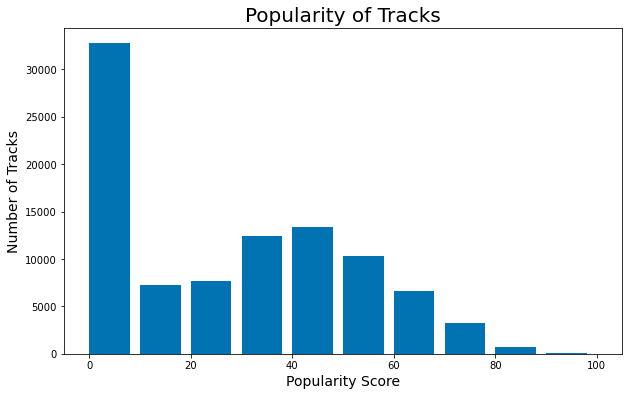

In [28]:
plt.figure(figsize=[10,6])
plt.hist(tracks_df['popularity'], width=8)
plt.title('Popularity of Tracks', fontsize=20)
plt.xlabel('Popularity Score', fontsize=14)
plt.ylabel('Number of Tracks', fontsize=14)
plt.show()

The majority of tracks have a very low popularity score.

In [29]:
tracks_df['popularity'].value_counts()

0      20920
1       2718
2       1527
39      1463
40      1445
       ...  
100        1
99         1
98         1
93         1
95         1
Name: popularity, Length: 101, dtype: int64

There are almost 21k tracks that have a popularity score of 0.  Let's have a look at these.

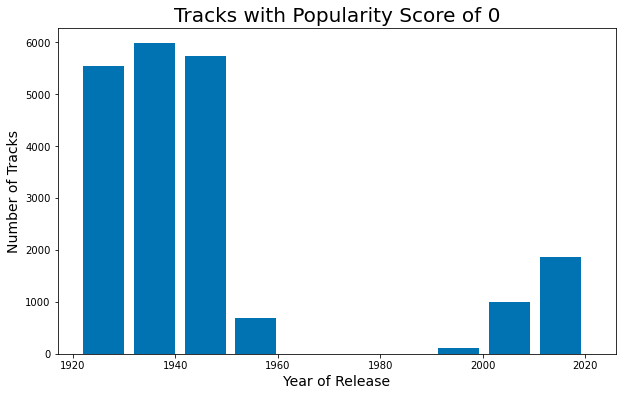

In [30]:
plt.figure(figsize=[10,6])
plt.hist(tracks_df[tracks_df['popularity']==0]['release_year'], width=8)
plt.title('Tracks with Popularity Score of 0', fontsize=20)
plt.xlabel('Year of Release', fontsize=14)
plt.ylabel('Number of Tracks', fontsize=14)
plt.show()

It looks like the majority of the tracks with 0 popularity score are from before 1960.  According to Spotify's API documentation, the popularity score is based mostly on the total number of plays the track has had and how recent those plays were.  Music genres that were popular in the early 1900s are not so popular today (as compared with e.g. Classic Rock of the 1980s which is still very popular today), this could account for the larger number of tracks with 0 popularity scores for pre-1950s.

## Who are the most popular artists in the GB Spotify market?

In [31]:
artist_popularity = tracks_df.groupby("artists").sum()["popularity"].sort_values(ascending=False)
artist_popularity.head(20)

artists
['The Beatles']                 17879
['Elvis Presley']               14484
['Queen']                       13718
['Fleetwood Mac']               13097
['Frank Sinatra']               11921
['The Rolling Stones']          11856
['Pink Floyd']                   9839
['Bob Marley & The Wailers']     9767
['David Bowie']                  9609
['Taylor Swift']                 9404
['Led Zeppelin']                 8854
['Bob Dylan']                    8588
['Billie Holiday']               7998
['Oasis']                        7415
['The Beach Boys']               7049
['Michael Jackson']              6888
['U2']                           6785
['Ella Fitzgerald']              6675
['Johnny Cash']                  6552
['AC/DC']                        6263
Name: popularity, dtype: int64

Although the artists column is intended as a list, the data was actually read in as a string, e.g. "['The Beatles']".  Let's remove the brackets and apostrophes so that our plots look neater.  We'll just drop the first and last two characters from each artist entry.  This isn't the right method in some cases e.g. if we had artists who had apostrophes in their names, or when there are multiple artists named on a track.  But since we can see that the top 20 artists are individual artists with no apostrophes in their names, this method will do us fine.

In [32]:
artist_popularity = pd.DataFrame(tracks_df.groupby("artists").sum()["popularity"].sort_values(ascending=False)).reset_index()
artist_popularity.columns = ["artists", "total_popularity"]
artist_popularity["artists"] = artist_popularity["artists"].str[2:-2]

### Look at top 20 most popular artists

In [33]:
top20_artists = artist_popularity.head(20)
top20_artists

,artists,total_popularity
0,The Beatles,17879
1,Elvis Presley,14484
2,Queen,13718
3,Fleetwood Mac,13097
4,Frank Sinatra,11921
5,The Rolling Stones,11856
6,Pink Floyd,9839
7,Bob Marley & The Wailers,9767
8,David Bowie,9609
9,Taylor Swift,9404


### Plot the total popularity scores of the top 20 artists

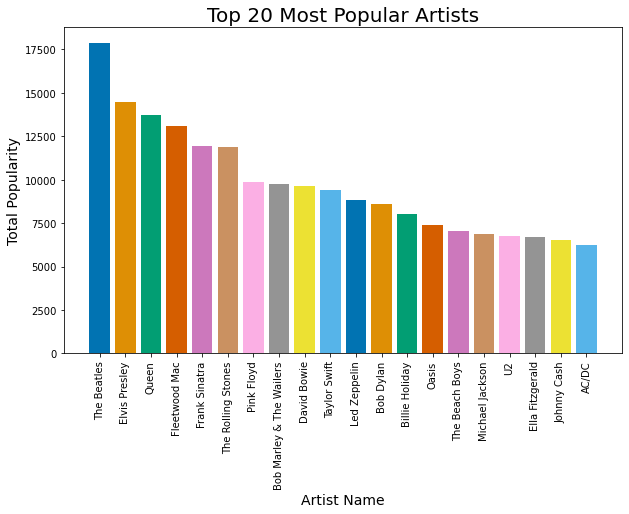

In [34]:
plt.figure(figsize=[10,6])
plt.bar(top20_artists["artists"], top20_artists["total_popularity"], color=color_palette20)
plt.title('Top 20 Most Popular Artists', fontsize=20)
plt.xticks(np.arange(20), rotation="vertical")
plt.xlabel('Artist Name', fontsize=14)
plt.ylabel('Total Popularity', fontsize=14)
plt.show()

The Beatles are the most popular artist on Spotify in the GB market.  Note that a lot of the artists in the top 20 have a large discography which could help boost their score.  An average would be better but if there are artists with only one or two very popular tracks, this could skew the results.  Instead, let's look at average popularity of artists but only if they have a fair discography.

### Look at average popularity of artists who have at least 10 tracks

In [35]:
min_10_tracks = pd.DataFrame(tracks_df['artists'].value_counts().loc[lambda x: x>=10]).reset_index()
min_10_tracks.columns = ["artists", "tracks"]

In [36]:
min_10_tracks

,artists,tracks
0,['Francisco Canaro'],849
1,['Tadeusz Dolega Mostowicz'],709
2,['Ignacio Corsini'],534
3,['Billie Holiday'],454
4,['Ella Fitzgerald'],435
...,...,...
1705,['Freddie King'],10
1706,['Jack Teagarden & His Band'],10
1707,['Sierra Nelson'],10
1708,"['Daddy Yankee', 'Snoop Dogg']",10


In [37]:
# Taking all the artists with 10+ tracks and joining back to dataframe to get the additional data back
tracks_df_min_10 = pd.merge(tracks_df, min_10_tracks, on="artists")

In [38]:
tracks_df_min_10

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,release_year,tracks
0,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,no,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.263,...,major,0.957,0.7970,0.000000,0.1480,0.655,102.009,1,1922,50
1,0OYGe21oScKJfanLyM7daU,Capítulo 2.8 - Banquero Anarquista,0,99100,no,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.676,0.235,...,minor,0.960,0.7940,0.000000,0.2100,0.724,96.777,3,1922,50
2,0PE42H6tslQuyMMiGRiqtb,Capítulo 2.25 - Banquero Anarquista,0,132700,no,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.750,0.229,...,major,0.955,0.5780,0.000000,0.3140,0.531,102.629,3,1922,50
3,0cC9CYjLRIzwchQ42xVnq6,Capítulo 1.23 - Banquero Anarquista,0,96600,no,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.687,0.198,...,minor,0.962,0.7540,0.000000,0.1970,0.478,78.453,1,1922,50
4,0eb1PfHxT6HnXvvdUOzmME,Capítulo 1.18 - Banquero Anarquista,0,103200,no,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.800,0.171,...,major,0.953,0.6700,0.000000,0.1230,0.693,59.613,3,1922,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57332,1X1Kx3taTItaQrBRzKzH22,Gangsta Zone,1,213000,yes,"['Daddy Yankee', 'Snoop Dogg']","['4VMYDCV2IEDYJArk749S6m', '7hJcb9fa4alzcOq3Ea...",2021-04-09,0.655,0.879,...,major,0.235,0.0321,0.000007,0.0679,0.657,184.027,4,2021,10
57333,3VejLq2bIC8ABuTK4DU8lA,Gangsta Zone,1,213000,yes,"['Daddy Yankee', 'Snoop Dogg']","['4VMYDCV2IEDYJArk749S6m', '7hJcb9fa4alzcOq3Ea...",2021-04-09,0.655,0.879,...,major,0.235,0.0321,0.000007,0.0679,0.657,184.027,4,2021,10
57334,47S9ZdzTa2ilVB2JIhwNai,Gangsta Zone,1,213000,yes,"['Daddy Yankee', 'Snoop Dogg']","['4VMYDCV2IEDYJArk749S6m', '7hJcb9fa4alzcOq3Ea...",2021-04-09,0.655,0.879,...,major,0.235,0.0321,0.000007,0.0679,0.657,184.027,4,2021,10
57335,4QPKyOafdHiznQrhp2P4JA,Gangsta Zone,2,213000,yes,"['Daddy Yankee', 'Snoop Dogg']","['4VMYDCV2IEDYJArk749S6m', '7hJcb9fa4alzcOq3Ea...",2021-04-09,0.655,0.879,...,major,0.235,0.0321,0.000007,0.0679,0.657,184.027,4,2021,10


In [39]:
artist_popularity_avg = pd.DataFrame(tracks_df_min_10.groupby("artists").mean()["popularity"].sort_values(ascending=False)).reset_index()
artist_popularity_avg.columns = ["artists", "avg_popularity"]
artist_popularity_avg["artists"] = artist_popularity_avg["artists"].str[2:-2]

In [40]:
top20_artists_avg = artist_popularity_avg.head(20)
top20_artists_avg

,artists,avg_popularity
0,XXXTENTACION,80.666667
1,Harry Styles,78.080000
2,Travis Scott,77.333333
3,Billie Eilish,77.133333
4,Lewis Capaldi,76.750000
5,Khalid,76.500000
6,Post Malone,76.000000
7,NF,75.636364
8,Ariana Grande,75.500000
9,Juice WRLD,75.270270


### Plot the average popularity scores for the top 20 artists

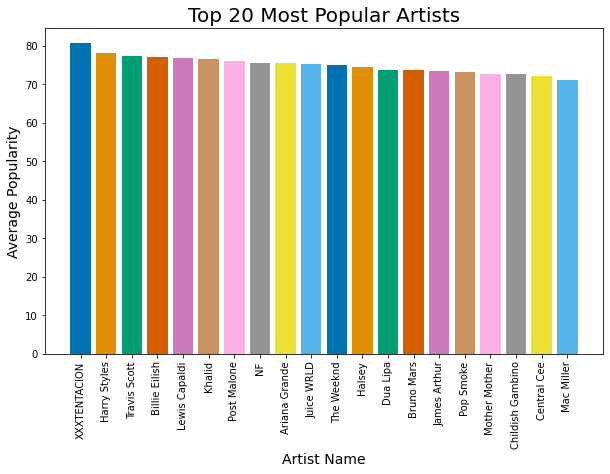

In [41]:
plt.figure(figsize=[10,6])
plt.bar(top20_artists_avg["artists"], top20_artists_avg["avg_popularity"], color=color_palette20)
plt.title('Top 20 Most Popular Artists', fontsize=20)
plt.xticks(np.arange(20), rotation="vertical")
plt.xlabel('Artist Name', fontsize=14)
plt.ylabel('Average Popularity', fontsize=14)
plt.show()

## What were the most popular tracks in the GB market?

In [42]:
# We'll take another copy of the dataframe and subset to just popularity score, artist, and track name for ease
# For the plot we want to combine the track name and artist so let's clean them up and create a new field we can use
tracks_df2 = tracks_df.copy()
tracks_df2 = tracks_df2[["popularity", "name", "artists"]]
tracks_df2["artists_cleaned"] = tracks_df2["artists"].str.replace("[']", "", regex=True)
tracks_df2["artists_cleaned"] = tracks_df2["artists_cleaned"].str[1:-1]
tracks_df2["track"] = tracks_df2["name"] + " - " + tracks_df2["artists_cleaned"]
tracks_df2

,popularity,name,artists,artists_cleaned,track
0,6,Carve,['Uli'],Uli,Carve - Uli
1,0,Capítulo 2.16 - Banquero Anarquista,['Fernando Pessoa'],Fernando Pessoa,Capítulo 2.16 - Banquero Anarquista - Fernando...
2,0,Vivo para Quererte - Remasterizado,['Ignacio Corsini'],Ignacio Corsini,Vivo para Quererte - Remasterizado - Ignacio C...
3,0,El Prisionero - Remasterizado,['Ignacio Corsini'],Ignacio Corsini,El Prisionero - Remasterizado - Ignacio Corsini
4,0,Lady of the Evening,['Dick Haymes'],Dick Haymes,Lady of the Evening - Dick Haymes
...,...,...,...,...,...
94464,2,Definitivamente,"['Daddy Yankee', 'Sech']","Daddy Yankee, Sech","Definitivamente - Daddy Yankee, Sech"
94465,1,Definitivamente,"['Daddy Yankee', 'Sech']","Daddy Yankee, Sech","Definitivamente - Daddy Yankee, Sech"
94466,0,Shaky Shaky - Remix,"['Daddy Yankee', 'Nicky Jam', 'Plan B', 'Rome ...","Daddy Yankee, Nicky Jam, Plan B, Rome & Urba","Shaky Shaky - Remix - Daddy Yankee, Nicky Jam,..."
94467,0,Si Supieras,"['Daddy Yankee', 'Wisin & Yandel']","Daddy Yankee, Wisin & Yandel","Si Supieras - Daddy Yankee, Wisin & Yandel"


In [43]:
# Take the top 20 more popular tracks
data = tracks_df2[["popularity", "track"]].sort_values("popularity", ascending=False).head(20)
data

,popularity,track
93970,100,Peaches (feat. Daniel Caesar & Giveon) - Justi...
93969,99,drivers license - Olivia Rodrigo
93977,98,Astronaut In The Ocean - Masked Wolf
93002,97,Save Your Tears - The Weeknd
93035,97,telepatía - Kali Uchis
93005,96,Blinding Lights - The Weeknd
93982,96,"Leave The Door Open - Bruno Mars, Anderson .Pa..."
92999,95,The Business - Tiësto
93971,94,Friday (feat. Mufasa & Hypeman) - Dopamine Re-...
93000,94,WITHOUT YOU - The Kid LAROI


In [44]:
labels = ['\n'.join(wrap(l, 40)) for l in data.track]

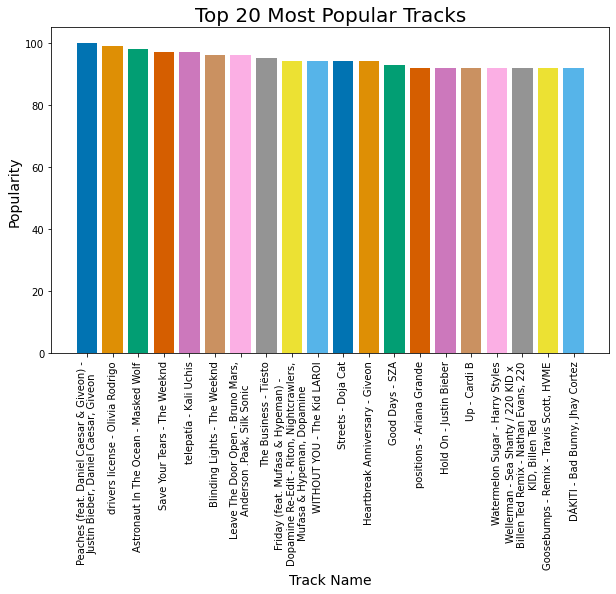

In [45]:
plt.figure(figsize=[10, 6])
plt.bar(data["track"], data["popularity"], color=color_palette20)
plt.title('Top 20 Most Popular Tracks', fontsize=20)
plt.xticks(np.arange(20), labels, rotation="vertical")
plt.xlabel('Track Name', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.show()

## How have audio features changed over time?

### Choose some of the continuous audio features and plot the mean value over time

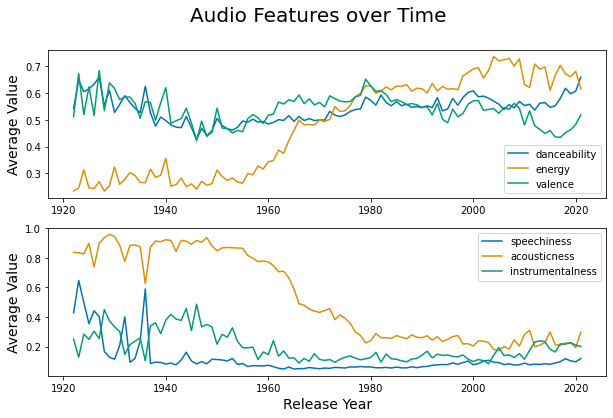

In [46]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot1 = ["danceability", "energy", "valence"]
plot2 = ["speechiness", "acousticness", "instrumentalness"]

for feature in plot1:
    sns.lineplot(ax=axes[0], data=tracks_df.groupby("release_year")[feature].mean(), label=feature)
for feature in plot2:
    sns.lineplot(ax=axes[1], data=tracks_df.groupby("release_year")[feature].mean(), label=feature)

# Tidy up the labels and titles of the charts
fig.suptitle("Audio Features over Time", fontsize=20)
axes[0].set_xlabel("")
axes[1].set_xlabel("Release Year", fontsize=14)
axes[0].set_ylabel("Average Value", fontsize=14)
axes[1].set_ylabel("Average Value", fontsize=14);

We can see that, as the years go on, tracks tended to have a higher energy score, and a lower acousticness score.  The decline in acousticness makes sense as songs released in the earlier 1900s would have been much more likely to feature more classical, non-electronic instruments.  Energy relates to the intensity and activity of the track.

## What makes a popular song?

Earlier we tried to build a multiple linear regression model to predict track popularity based on audio features of that track, however, our model had an R-squared of 0.374.  We did note that acousticness had the largest negative effect on popularity in the model, and explicit_yes had the largest positive effect on popularity.

Let's explore some of the features further using visualisations.

### Look at count of tracks by key

In [51]:
tracks_df["key"].value_counts().sort_values(ascending=False)

C        11764
G        11256
D         9939
A         9725
F         9137
C#/Db     7613
E         7114
A#/Bb     6755
G#/Ab     5951
B         5929
F#/Gb     5066
D#/Eb     4220
Name: key, dtype: int64

### Look at average popularity by key

In [52]:
key_popularity = pd.DataFrame(tracks_df.groupby("key").mean()["popularity"]).reset_index()
key_popularity

,key,popularity
0,A,29.991260
1,A#/Bb,25.872095
2,B,31.107269
3,C,28.370452
4,C#/Db,27.475634
5,D,29.128383
6,D#/Eb,21.245024
7,E,30.239949
8,F,26.440954
9,F#/Gb,29.452033


### Plot the average popularity by key

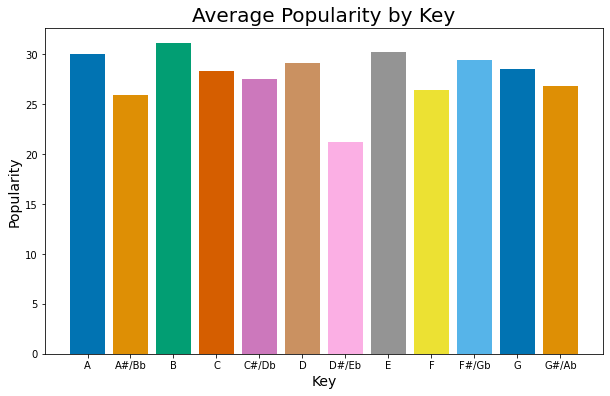

In [53]:
plt.figure(figsize=[10, 6])
plt.bar(key_popularity["key"], key_popularity["popularity"], color=color_palette20)
plt.title('Average Popularity by Key', fontsize=20)
plt.xlabel('Key', fontsize=14)
plt.ylabel('Popularity', fontsize=14)
plt.show()

The highest average popularity scores were observed in tracks in the keys B, A, and E.  The average popularity of tracks in the D#/Eb key were significantly lower than the other keys.

### Look at count of tracks by whether or not the track was explicit

In [54]:
tracks_df["explicit"].value_counts(ascending=False)

no     90093
yes     4376
Name: explicit, dtype: int64

### Look at average popularity based on whether or not the track was explicit

In [55]:
explicit_popularity = pd.DataFrame(tracks_df.groupby("explicit").mean()["popularity"]).reset_index()
explicit_popularity

,explicit,popularity
0,no,26.841542
1,yes,55.051188


There is quite a large difference in average popularity in explicit vs non-explicit songs, with songs containing explicit content having a higher average popularity.  This isn't too much of a surprise given the results of the regression model earlier.

### Look at count of tracks based on mode

In [56]:
tracks_df["mode"].value_counts(ascending=False)

major    65559
minor    28910
Name: mode, dtype: int64

### Look at average popularity based on mode (major/minor key)

In [57]:
mode_popularity = pd.DataFrame(tracks_df.groupby("mode").mean()["popularity"]).reset_index()
mode_popularity

,mode,popularity
0,major,27.666941
1,minor,29.239779


There isn't much of a difference in popularity between songs written in the major or minor key.

### Plot the average popularity by explicitness and mode

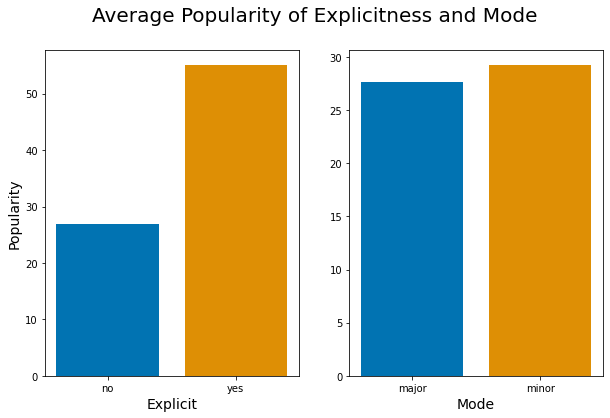

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))
axes[0].bar(explicit_popularity["explicit"], explicit_popularity["popularity"], color=color_palette20)
axes[1].bar(mode_popularity["mode"], mode_popularity["popularity"], color=color_palette20)
fig.suptitle("Average Popularity of Explicitness and Mode", fontsize=20)
axes[0].set_xlabel("Explicit", fontsize=14)
axes[1].set_xlabel("Mode", fontsize=14)
axes[0].set_ylabel("Popularity", fontsize=14);

There is not much of a difference in track popularity between major and minor modes, but there is a significantly higher average popularity of songs containing explicit content than tracks with no explicit content.  The dataset we're working with has tracks that were released up to the 15th April 2021.  In the week of 16th April 2021, exactly half of the top 50 Spotify tracks in the UK contained explicit content.

### Plot change in audio features by popularity

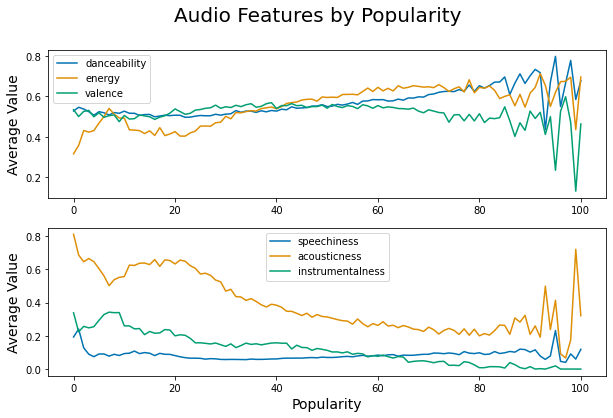

In [59]:
fig, axes = plt.subplots(2, 1, figsize=(10, 6))

plot1 = ["danceability", "energy", "valence"]
plot2 = ["speechiness", "acousticness", "instrumentalness"]

for feature in plot1:
    sns.lineplot(ax=axes[0], data=tracks_df.groupby("popularity")[feature].mean(), label=feature)
for feature in plot2:
    sns.lineplot(ax=axes[1], data=tracks_df.groupby("popularity")[feature].mean(), label=feature)

# Tidy up the labels and titles of the charts
fig.suptitle("Audio Features by Popularity", fontsize=20)
axes[0].set_xlabel("")
axes[1].set_xlabel("Popularity", fontsize=14)
axes[0].set_ylabel("Average Value", fontsize=14)
axes[1].set_ylabel("Average Value", fontsize=14);

### Check how many tracks have a popularity score above 90

In [60]:
tracks_df['popularity'].value_counts().sort_index().tail(11)

90     9
91     9
92     8
93     1
94     4
95     1
96     2
97     2
98     1
99     1
100    1
Name: popularity, dtype: int64

We can see that songs with higher popularity scores tend to have lower acousticness scores.  Again, this lines up with the results of the regression model.  Instrumentalness scores had a slight decline as the song popularity increased, and energy scores were slightly higher in songs with higher popularity.  The other features remained mostly consistent.  We did see more erratic activity in tracks with popularity scores above ~90, but there are small volumes of tracks with scores that high.

From our analysis it seems to be hard to identify what leads to a popular song in the GB market.  But writing a song that contains explicit content, is not acoustic, contains vocals (not instrumental), and has high energy seems to be a good place to start!